# Optical Monte Carlo simulations

Code used for my (Ben Wilson's) 4th year uni project.

Disclaimer: there may be some very bad code here. Most of it was scraped together over a month or so amidst frantic report writing, lab work and a general sense of desperation

### Imports, including from local `helpers.py` file
- `conda` should provide most of the required modules but a few extras will need to be installed
- Make sure to use `autoreload` if making changes to `helpers.py`

In [7]:
from helpers import *

import networkx as nx
from skimage.util import img_as_ubyte, img_as_float
from skimage.transform import downscale_local_mean
from skimage import io
from scipy.spatial.transform import Rotation as Rot
from scipy.stats import norm
from skimage import filters

### Whether to execute certain code cells along the way to check everything is in order and as expected 
_(no time to write unit tests when you're in dissertation crunch mode!)_

In [8]:
full_exec = True

### Helper functions and code

In [9]:
def gen_rand_direction():
    rand_vec = np.random.normal(size=3)
    # avoid while loop when possible
    while np.sum(np.square(rand_vec)) < 0.001:
        rand_vec = np.random.normal(size=3)
    
    return rand_vec / np.sqrt(np.sum(np.square(rand_vec)))
    
def gen_rand_orthogonal(base_vec):

    rand_vec = gen_rand_direction()
    dot = rand_vec @ base_vec
    
    # avoid while loop when possible
    while np.abs(dot) < 0.001:
        rand_vec = gen_rand_direction()
        dot = rand_vec @ base_vec

    perp = rand_vec - base_vec * (rand_vec @ base_vec)
    perp /= np.sqrt(np.sum(np.square(perp)))

    return perp
    
def gen_scatter_direction(base_vec, g):
    cos_theta = (1+g**2)/(2*g)
    cos_theta -= (1-g**2)**2/(2*g*(1-g+2*g*np.random.uniform())**2)
    theta = np.arccos(cos_theta)
    orthog = gen_rand_orthogonal(base_vec)
    r = Rot.from_rotvec(theta * orthog)
    return r.apply(base_vec)

[ 0.99954066 -0.02803755 -0.0115054 ]
start
end


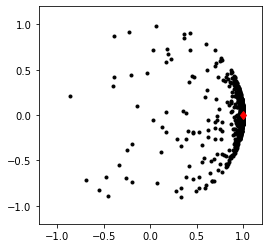

In [10]:
if full_exec:
    v = gen_scatter_direction(np.array([1,0,0]), .92)    
    print(v)
    
    plt.figure(figsize=(4,4))
    
    print("start")
    for i in range(1000):
        v = gen_scatter_direction(np.array([1,0,0]), 0.92)
        plt.plot(v[0], v[1], "k.")
    print("end")

    plt.plot(1,0,"rd")

    plt.xlim(-1.2,1.2)
    plt.ylim(-1.2,1.2)

    plt.show()

## Classes to define biofilm geometries in various parameterisations
A few options available here

In [11]:
class BiofilmGeometry(Pickleable):
    stem = "optics_sims/geometries/"
    
    def __init__(self, R=None, aspect=None, H=None):
        super().__init__()
        if R is not None and aspect is not None:
            self.R = R
            self.aspect = aspect
            self.H = R * aspect
        elif R is not None and H is not None:
            self.R = R
            self.H = H
            self.aspect = H/R
        elif H is not None and aspect is not None:
            self.H = H
            self.aspect = aspect
            self.R = H/aspect
        elif H is not None:
            self.aspect = 0.18
            self.H = H
            self.R = H/0.18
        elif R is not None:
            self.aspect = 0.18
            self.R = R
            self.H = R*0.18
        else:
            self.R = 700
            if aspect is not None:
                self.aspect = aspect
            else:
                self.aspect = 0.18
            self.H = self.aspect*self.R
        
        self.R2 = self.R**2
        
    def r(self, h):
        return np.sqrt(self.R2 - np.square(h/self.aspect))
    
    def h(self, x, y=0):
        return self.aspect*np.sqrt(self.R2 - (np.square(x) + np.square(y)))


In [12]:
class FlatTopBiofilm(BiofilmGeometry):
    
    def __init__(self, R=None, aspect=None, H=None, alpha=0.15):
        super().__init__(R, aspect, H)
        self.alpha = alpha
        
    def h(self, x, y=0):
        r = np.sqrt(np.square(x) + np.square(y))
        return self.H*(np.maximum(0,\
                        1 - np.square((np.abs(r)-self.alpha*self.R)/(self.R*(1-self.alpha))))\
                    *(np.abs(r)>self.alpha*self.R) + 1*(np.abs(r)<=self.alpha*self.R))
    
    def r(self, h):
        return (np.abs(h) < self.H)*(self.R*(1-self.alpha)*np.sqrt(np.maximum(0, 1-np.abs(h)/self.H)) + self.R*self.alpha)
    
gm = FlatTopBiofilm().save("standard_biofilm_geometry").load()

class CylinderBiofilm(Pickleable):
    
    def __init__(self, R, H):
        super().__init__()
        self.aspect = H/R
        self.R = R
        self.H = H
        self.R2 = self.R**2
        
    def r(self, h=0):
        return (h<self.H) * self.R*np.ones_like(h)
    
    def h(self, x=0, y=0):
        return ((x**2 + y**2)<self.R2) * self.H*np.ones_like(x)

saving to optics_sims/geometries/standard_biofilm_geometry.pickle


## Where the physics happens

See later code for example usage (generally the functions are quite poorly documented, sorry!)

In [13]:
class Optics_Simulation(Pickleable):
    
    def __init__(self, bf_geom=None, g=0.92, l_mfp=20, max_scatters=100, absorb_prop=0):
        super().__init__()
        self.geom = bf_geom
        self.max_scatters = max_scatters
        self.g = g
        self.l_mfp = l_mfp
        self.scatter_prop = 1 - absorb_prop
        self.absorb_prop = absorb_prop
        
    def handle_image_point(self, xd, yd, photon_i):
        pass

    def run(self, emitter_pos, fp_z=0, N_photons=500, aperture_pos=None, save_positions=False, do_tqdm=False, inverted=True):
        
        up = 1 if inverted else -1 
        if aperture_pos is None:
            aperture_pos = np.array(emitter_pos[:2])
        
        if save_positions:
            self.positions = [[emitter_pos]]*N_photons

        self.photon_imaged = np.zeros(N_photons).astype(bool)
        self.photon_detected = np.zeros(N_photons).astype(bool)
        self.photon_scatters = np.zeros(N_photons)

        generator = tqdm(range(N_photons)) if do_tqdm else range(N_photons)
        for photon_i in generator:
            x = np.array(emitter_pos)
            v = gen_rand_direction()
            v[2] = np.abs(v[2]) * up
            local_r = self.geom.r(x[2])

            for scatter_i in range(self.max_scatters+1):
                path_len = -np.log(np.random.random())*self.l_mfp
                new_x = x + path_len * v
                local_r = self.geom.r(new_x[2])

                if save_positions:
                    self.positions[photon_i].append(new_x)
                
                top_bottom_criteria = ((new_x[0]**2 + new_x[1]**2 > local_r**2), (new_x[2] < 0))
                out_incorrect_side = top_bottom_criteria[int(inverted)]
                out_correct_side = top_bottom_criteria[1-int(inverted)]
                
                if out_correct_side:
                    self.photon_imaged[photon_i] = True
    
                    if v[2]*up < 1e-4:
                        break # exited right side, but going in wrong direction
                    
                    # image plane coords
                    xd = aperture_pos[0] - x[0] - up*v[0]/np.sqrt(v[0]**2 + v[2]**2) * (fp_z - x[2])
                    yd = aperture_pos[1] - x[1] - up*v[1]/np.sqrt(v[1]**2 + v[2]**2) * (fp_z - x[2])
                    
                    self.handle_image_point(xd, yd, v, photon_i)
                    break

                if (out_incorrect_side) or (new_x[0]**2 + new_x[1]**2 > self.geom.R2): # exited out bottom or side
                    break 

                if (self.absorb_prop > 0 and np.random.random() < self.absorb_prop): # absorbed
                    break

                v = gen_scatter_direction(v, self.g)
                x = new_x
        
            self.photon_scatters[photon_i] = scatter_i
                
        if save_positions:
            self.positions = np.array(self.positions)
        
        self.fraction_detected = np.mean(self.photon_detected)
        self.fraction_imaged = np.mean(self.photon_imaged) 
        self.mean_n_scatters = np.mean(self.photon_scatters)
        
        return self.fraction_detected

    
class CLSM_Simulation(Optics_Simulation):
    stem = "optics_sims/CLSM/"
    
    def __init__(self, bf_geom, aperture_r=1, **kwargs):
        super().__init__(bf_geom, **kwargs)
    
        self.aperture_r = aperture_r
        self.aperture_r_sq = aperture_r ** 2
    
    def handle_image_point(self, xd, yd, v, photon_i):
        
        if np.sqrt(v[0]**2 + v[1]**2) > .6:
            return # did not enter objective aperture
        
        if xd**2 + yd**2 < self.aperture_r_sq**2:
            self.photon_detected[photon_i] = True
            
        if self.save_images:
            self.images.append([xd,yd])
            
    def run(self, emitter_pos, save_images=False, **kwargs):
        
        self.save_images = save_images
        
        if save_images:
            self.images = []
            
        super().run(emitter_pos, **kwargs)
        
        if save_images:
            self.images = np.array(self.images)

            
class Widefield_Simulation(Optics_Simulation):
    stem = "optics_sims/WF/"
    
    def __init__(self, bf_geom, CCD_xs, CCD_ys, NA=1, **kwargs):
        super().__init__(bf_geom, **kwargs)
        self.CCD_x_um_per_px = CCD_xs[1] - CCD_xs[0]
        self.CCD_y_um_per_px = CCD_ys[1] - CCD_ys[0]
        self.CCD_xs = CCD_xs
        self.CCD_ys = CCD_ys
        self.CCD_w = len(CCD_xs)
        self.CCD_h = len(CCD_ys)
        self.CCD_min_x = CCD_xs[0] - 0.5 * self.CCD_x_um_per_px
        self.CCD_min_y = CCD_ys[0] - 0.5 * self.CCD_y_um_per_px
        self.CCD_max_x = CCD_xs[-1] + 0.5 * self.CCD_x_um_per_px
        self.CCD_max_y = CCD_ys[-1] + 0.5 * self.CCD_y_um_per_px
        self.image = np.zeros((self.CCD_h, self.CCD_w))
        self.NA = NA

        # self.images = []
        
    def handle_image_point(self, xd, yd, v, photon_i):
        xd, yd = -xd, -yd
        if xd < self.CCD_min_x or xd > self.CCD_max_x:
            return
        if yd < self.CCD_min_y or yd > self.CCD_max_y:
            return

        if np.sqrt(v[0]**2 + v[1]**2) > self.NA:
            return # did not enter aperture
        
        self.photon_detected[photon_i] = True
        
        if xd > self.CCD_xs[-1] - 0.5 * self.CCD_x_um_per_px:
            xi = self.CCD_w-1
        else:
            xi = np.searchsorted(self.CCD_xs, xd)
            if self.CCD_xs[xi] - xd > 0.5 * self.CCD_x_um_per_px:
                xi -= 1
                
        if yd > self.CCD_ys[-1] - 0.5 * self.CCD_y_um_per_px:
            yi = self.CCD_h-1
        else:
            yi = np.searchsorted(self.CCD_ys, yd)
            if self.CCD_ys[yi] - yd > 0.5 * self.CCD_y_um_per_px:
                yi -= 1

        self.image[yi,xi] += 1
        # self.images.append([xi,yi])
    
    def run(self, emitter_pos, **kwargs):
        super().run(emitter_pos, **kwargs)

An alternative linspace function that gives N-1 values midway between regular linspace points

In [14]:
def linspace1(*args):
    if len(args) == 3:
        args = args[:2] + (args[2]+1,)        
    space0 = np.linspace(*args)
    return 0.5*(space0[1:]+space0[:-1])

In [15]:
def hslice_xy_coords(h, geom, N=31):
    xs0, ys0 = linspace1(-geom.R,geom.R,N), linspace1(-geom.R,geom.R,N)
    X0, Y0 = np.meshgrid(xs0, ys0)
    mask = X0**2+Y0**2<=geom.r(h)**2
    return np.vstack([X0[mask], Y0[mask]])

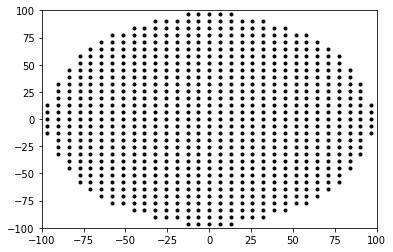

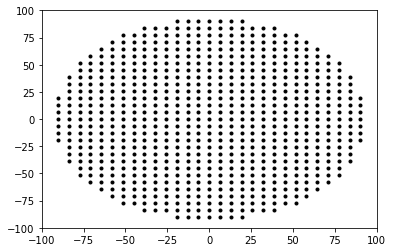

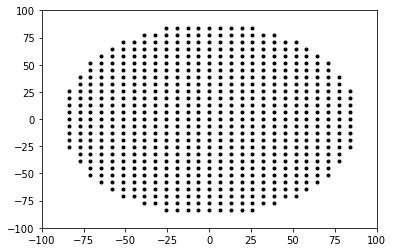

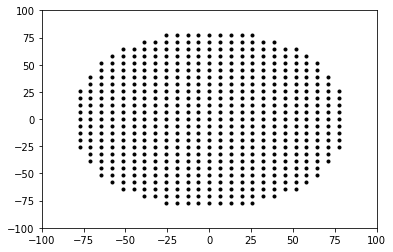

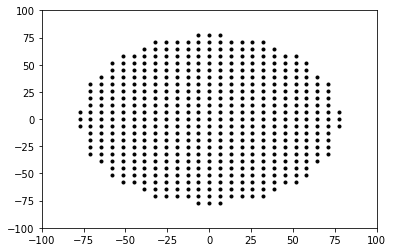

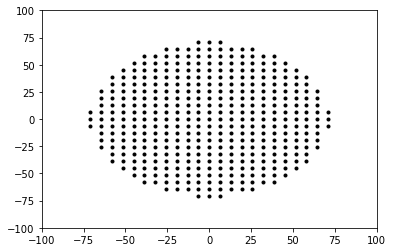

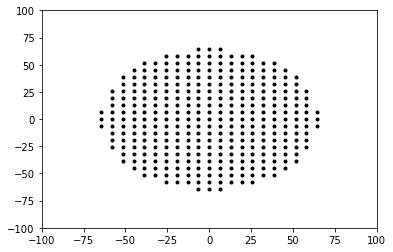

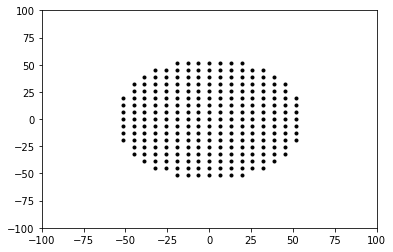

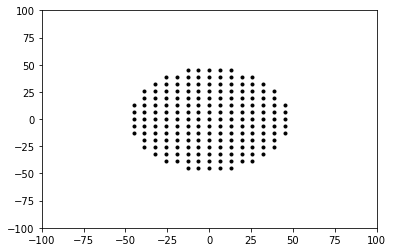

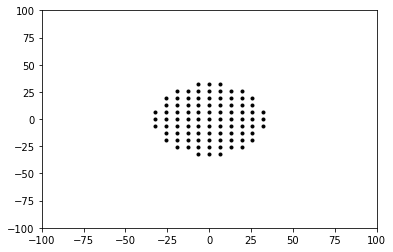

In [16]:
geom1 = FlatTopBiofilm(R=100, H=100)
if full_exec:
    for hi, h in enumerate(linspace1(0, geom1.H, 10)):
        xys = hslice_xy_coords(h, geom1)
        plt.plot(xys[0], xys[1], "k.")

        plt.xlim(-geom1.R,geom1.R)
        plt.ylim(-geom1.R,geom1.R)
        plt.show()

In [17]:
gm = FlatTopBiofilm() # default.

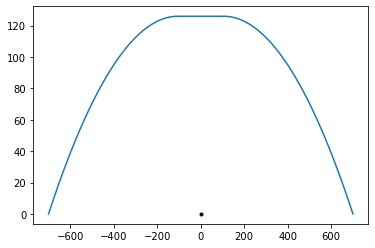

  0%|          | 0/1000 [00:00<?, ?it/s]

plotting...


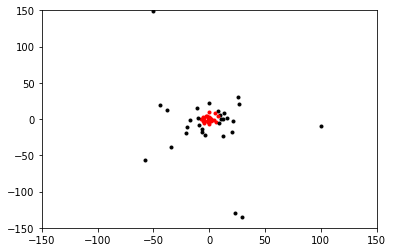

In [18]:
if full_exec:

    rd = 10
    h = 0.1
    x = 0#np.random.uniform(-gm.r(h), gm.r(h))
    xs = np.linspace(-gm.R, gm.R, 100)
    plt.plot(xs, gm.h(xs))
    plt.plot(x, h, "k.")
    plt.show()
    
    sim = CLSM_Simulation(gm, l_mfp=500, max_scatters=50)
    sim.run([x,0,h], fp_z=h, N_photons=1000, save_images=True, do_tqdm=True)
    
    print("plotting...")
    for img in sim.images:
        accepted = np.sum(np.square(img)) < rd**2
        if accepted:
            plt.plot(img[0], img[1], "r.")
        else:
            plt.plot(img[0], img[1], "k.")
            
    plt.xlim(-150, 150)
    plt.ylim(-150, 150)
    plt.show()
    

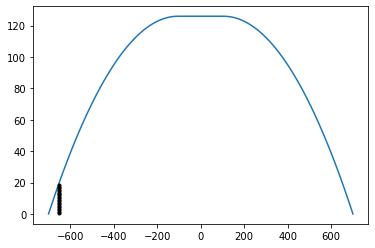

  0%|          | 0/20 [00:00<?, ?it/s]

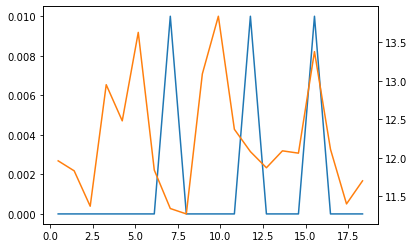

In [28]:
if full_exec:
    x = np.random.uniform(-gm.R, gm.R)
    xs = np.linspace(-gm.R, gm.R, 100)
    hs = linspace1(0, gm.h(x), 20)
    
    plt.plot(xs, gm.h(xs))
    plt.plot([x]*len(hs), hs, "k.")
    plt.show()

    sims = [CLSM_Simulation(gm, aperture_r=1) for i in range(len(hs))]

    for hi, h in enumerate(tqdm(hs)):
        sims[hi].run([0,0,h], fp_z=h, N_photons=100)

    plt.plot(hs,[sim.fraction_detected for sim in sims])
    plt.twinx()
    plt.plot(hs,[sim.mean_n_scatters for sim in sims],"tab:orange")
    plt.show()

In [29]:
def modelled_frac_CLSM_hits(sim1):
    rs = np.sqrt(np.sum(np.square(sim1.images), axis=1))
    perfect_mask = rs==0
    n_perfect = np.sum(perfect_mask)
    n_not = len(rs) - n_perfect
    
    if n_not <= 1:
        return sim1.fraction_imaged
    
    log_rs = np.log(rs[~perfect_mask])
    log_r_aperture = np.log(sim1.aperture_r)
        
    fraction_hit = norm.cdf((log_r_aperture-np.mean(log_rs))/np.std(log_rs))
    overall_frac = (n_perfect + n_not * fraction_hit) / len(rs)
    return overall_frac * sim1.fraction_imaged

In [19]:
def show_results(sim, gm):
    xs = linspace1(-gm.R, gm.R, len(sim[0]))
    hs = linspace1(0, gm.H, len(sim))

    results = np.zeros((len(hs), len(xs))) * np.nan
    for xi, x in enumerate(xs):
        for hi, h in enumerate(hs):
            if np.abs(x) < gm.r(h):
                results[hi][xi] = sim[xi][hi].fraction_detected

    plt.imshow(results, extent=[-gm.R,gm.R,0,gm.H], aspect="auto",origin="lower")        
    plt.plot(xs, gm.h(xs), "tab:orange")
    # plt.show()
    
def show_results1(sim, gm): # use Guassian model for off-centre photons to get better Monte Carlo estimates - this was verified to be fairly accurate
    xs = linspace1(-gm.R, gm.R, len(sim[0]))
    hs = linspace1(0, gm.H, len(sim))
    
    sum1 = 0
    sum2 = 0
    results = np.zeros((len(hs), len(xs))) * np.nan
    for xi, x in enumerate(xs):
        for hi, h in enumerate(hs):
            if np.abs(x) < gm.r(h) and sim[xi][hi].save_images:
                results[hi][xi] = modelled_frac_CLSM_hits(sim[xi][hi])
                sum1 += results[hi][xi]
                sum2 += sim[xi][hi].fraction_detected
    
    ratio = sum2/sum1
    results *= ratio
    
    plt.imshow(results, extent=[-gm.R,gm.R,0,gm.H], aspect="auto",origin="lower")        
    plt.plot(xs, gm.h(xs), "tab:orange")
    # plt.show()
    return results

# Example: Simulate CLSM photon detections with the beam focus moving across a biofilm cross-section

When playing around with simulations I mostly just stored results in session memory by doing eg `CLSM_40um_scatter = sim.copy()`.

Parameters for CLSM:
- `g` is a scattering distribution parameter
- `aperture_r` is the radius of the simulated CLSM aperture
- `l_mfp` is the mean free path between photon collisions (1/collision rate per unit distance)
- `max_scatters` is the number of scatters before a photon is disregarded from the simulation
- `absorb_prop` is the proportion of photons absorbed on a collision. Set to 0 for only absorption or 1 for only scattering

In simulation.run():
- first arg is where photons are emitted from (in random directions)
- `fp_z` is the z position of the focal plane
- `N_photons` is how many photons to simulate
- `save_images` is whether to store the image positions of the photons

In [20]:
xs = linspace1(-gm.R, gm.R, 31)
hs = linspace1(0, gm.H, 31)
# print(gm.H)
sim = [[CLSM_Simulation(gm, g=.85, aperture_r=0.54, l_mfp=40, max_scatters=50, absorb_prop=1) 
            for i in range(len(hs))] 
            for j in range(len(xs))]

for xi, x in enumerate(tqdm(xs)):
    for hi, h in enumerate(hs):
        if np.abs(x) > gm.r(h):
            pass
        else:
            sim[xi][hi].run([x,0,h], fp_z=h, N_photons=2000, save_images=True)

  0%|          | 0/31 [00:00<?, ?it/s]

In [21]:
example_simulation = sim.copy()

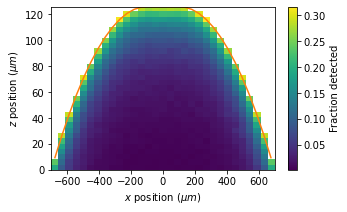

In [30]:
plt.figure(figsize=(5,3))
show_results1(example_simulation, gm)
cb = plt.colorbar(); cb.set_label("Fraction detected")
plt.ylabel("$z$ position ($\mu m$)"); plt.xlabel("$x$ position ($\mu m$)")
plt.savefig("figs/CLSM_pic1.svg")

Simulated image when firing 100 photos from a couple positions at halfway up the biofilm. Bottom left: in focus, top right: out of focus, but still a lot of photons captured


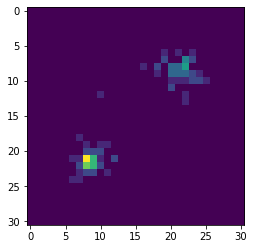

In [34]:
if full_exec:
    xs, ys = np.linspace(-700,700,31), np.linspace(-700,700,31)
    print("Simulated image when firing 100 photos from a couple positions at halfway up the biofilm. Bottom left: in focus, top right: out of focus, but still a lot of photons captured")
    sim = Widefield_Simulation(gm, xs, ys, g=.85, l_mfp=10, max_scatters=200)
    sim.run(np.array([-300,300,.5*gm.H]), fp_z=.5*gm.H, N_photons=100, aperture_pos=np.array([0,0]), inverted=False)
    sim.run(np.array([300,-300,.5*gm.H]), fp_z=gm.H, N_photons=100, aperture_pos=np.array([0,0]), inverted=False)
    plt.imshow(sim.image)
    plt.show()

# Example: Simulate widefield image captures

When playing around with simulations I mostly just stored results in session memory by doing eg `CLSM_40um_scatter = sim.copy()`.

Parameters for simulation:
- All the same as before

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/680 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/556 [00:00<?, ?it/s]

  0%|          | 0/492 [00:00<?, ?it/s]

  0%|          | 0/432 [00:00<?, ?it/s]

  0%|          | 0/376 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/232 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

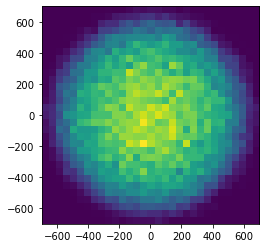

In [35]:
xs, ys = np.linspace(-700,700,31), np.linspace(-700,700,31)

sim = Widefield_Simulation(gm, xs, ys, g=.85, l_mfp=30, max_scatters=100, absorb_prop=0)

hs = linspace1(0,gm.H,10)
for h in tqdm(hs):
    pts = hslice_xy_coords(h, gm, N=30)
    for pt in tqdm(pts.T):
        sim.run(np.array([pt[0],pt[1],h]), fp_z=.5*gm.H, N_photons=20, aperture_pos=np.array([0,0]), do_tqdm=False, inverted=False)

plt.imshow(sim.image, extent=[xs[0],xs[-1],ys[0],ys[-1]])

### Saving a simulation to persistent storage
Note that this is just pickling the object, so not good for long term persistent storage, just between sessions on jupyter

In [36]:
sim.save("g=0_85_mfp=30_photons=20_scatter")

saving to optics_sims/WF/g=0_85_mfp=30_photons=20_scatter.pickle


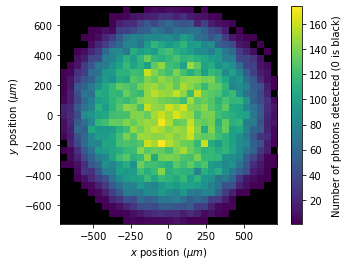

In [37]:
sim1= Widefield_Simulation.load_name("g=0_85_mfp=30_photons=20_scatter")
im1= sim1.image
im1[im1==0] = np.nan
plt.figure(figsize=(5,4))
w = (xs[-1] - xs[0]) + (xs[1] - xs[0])
plt.imshow(im1, extent=[-w/2, w/2,-w/2, w/2])#[im1[:,:20], im2[:,:10]]))
# plt.imshow(np.vstack([im1, im2]), extent=[-w/2, w/2, 0, 2*w])#[im1[:,:20], im2[:,:10]]))
plt.gca().set_facecolor("k")
plt.colorbar().set_label("Number of photons detected (0 is black)")
plt.xlabel("$x$ position ($\mu m$)")
plt.ylabel("$y$ position ($\mu m$)");

### Comparing scatter and absorb simulations

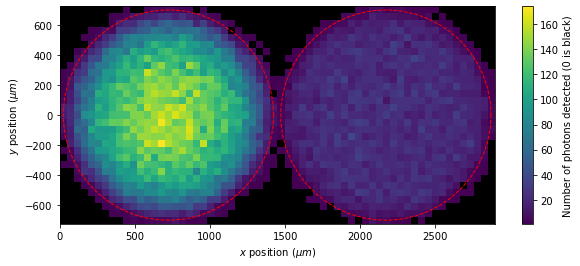

In [39]:
sim1, sim2 = Widefield_Simulation.load_name("g=0_85_mfp=30_photons=20_scatter"), Widefield_Simulation.load_name("g=0_85_mfp=30_photons=20_absorb")
im1, im2 = sim1.image, sim2.image
im1[im1==0] = np.nan; im2[im2==0] = np.nan
plt.figure(figsize=(5*2,4))
w0 = (xs[-1] - xs[0]) + (xs[1] - xs[0])
plt.imshow(np.hstack([im1, im2]), extent=[0, 2*w,-w/2, w/2])
thetas = np.linspace(0, 2*np.pi)
dxs, dys = gm.R * np.cos(thetas), gm.R * np.sin(thetas)
plt.plot(.5*w0 + dxs, dys, "r--", lw=1)
plt.plot(1.5*w0 + dxs, dys, "r--", lw=1)

plt.gca().set_facecolor("k")
plt.colorbar().set_label("Number of photons detected (0 is black)")
plt.xlabel("$x$ position ($\mu m$)")
plt.ylabel("$y$ position ($\mu m$)")
plt.show()

### Line profiles of the above
Thrown together for final presentation

In [40]:
import scipy as sp

def get_line_data1(img, smooth=False, n_thetas=36, start_n_pis=0, end_n_pis=2, reverse=False, double=False, plots=False):
    all_lines, all_ends = [],[]

    ys, xs = np.arange(h), np.arange(w)
    f = sp.interpolate.RectBivariateSpline(xs, ys, img)
    thetas = np.linspace(start_n_pis*np.pi, end_n_pis*np.pi, n_thetas)[:-1]
    lines = []

    for i, theta in enumerate(thetas):
        if double:
            line_rs = np.arange(-h-1, h)
        else:
            line_rs = np.arange(h)
            
        if reverse:
            line_rs = line_rs[::-1]
        line_xs = line_rs * np.cos(theta) + cx
        line_ys = line_rs * np.sin(theta) + cy
        fs = f(line_xs, line_ys, grid=False)
        if smooth:
            fs = gaussian_filter1d(fs, smooth)
        lines.append(fs)
        if plots:
            plt.plot(line_xs, line_ys)


    lines = np.array(lines)

    return lines

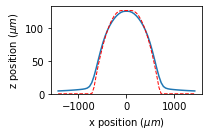

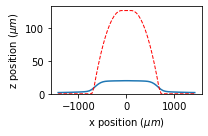

In [41]:
for i, sim in enumerate([Widefield_Simulation.load_name("g=0_85_mfp=30_photons=20_scatter"), Widefield_Simulation.load_name("g=0_85_mfp=30_photons=20_absorb")]):
    
    plt.figure(figsize=(3,2))
    YFP = skimage.filters.gaussian(sim.image,2)
    h,w=YFP.shape
    cx, cy = len(YFP)/2, len(YFP)/2
    l = get_line_data1(YFP)
    line = l.T.mean(1)
    line = np.hstack([line[::-1], line])
    xs1 = linspace1(-w0, w0, len(line))
    xs2 = linspace1(-w0, w0, len(line))
    hs1 = gm.h(xs1)
    plt.plot(xs2, line*.85, label="Estimated profile")
    
    plt.plot(xs1, hs1, "r--", lw=1, label="True profile")
    plt.xlabel("x position ($\mu m$)")
    plt.ylabel("z position ($\mu m$)")
    plt.ylim(0,None)
    plt.tight_layout()
    

# Below here, things are mostly experiments

If I recall correctly the below cell is comparing images where only a portion of a biofilm is imaged vs when the whole biofilm is imaged as an attempt to explain why biofilms are dimmer when an image is captured at their edges.
The gaussian blur helps make differences more visually apparent at low photon counts.

In [42]:
sim1, sim2 = Widefield_Simulation.load_name("g=92_mfp=10_photons=10"), Widefield_Simulation.load_name("NA_6_g=92_mfp=10_photons=10")
im1, im2 = skimage.filters.gaussian(sim1.image, 1), skimage.filters.gaussian(sim2.image, 1)

plt.figure(figsize=(5*2,5))
plt.imshow(np.hstack([im1, im2]))#[im1[:,:20], im2[:,:10]]))
plt.show()
plt.imshow(im1)
plt.show()
plt.imshow(im2)
# plt.imshow(np.hstack([sim1.image[:,:20], sim2.image[:,:10]]))
plt.show()
sim1, sim2 = Widefield_Simulation.load_name("opposite_shifted_g=92_mfp=10_photons=10_illumdelta_50"), Widefield_Simulation.load_name("shifted_g=92_mfp=10_photons=10_illumdelta_50")
im1, im2 = skimage.filters.gaussian(sim1.image, 1, mode="reflect"), skimage.filters.gaussian(sim2.image, 1, mode="reflect")
plt.figure(figsize=(5*2,5))
plt.imshow(np.hstack([im1[:,10:-1], im2[:,:10], im1[:,10:19]]))
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'optics_sims/WF/g=92_mfp=10_photons=10.pickle'

## Next steps to take (As planned for if I had more time during project)

- With cylinder geometry, find CLSM intensity vs non dimensional scattering and non dimensional absorption lengths. Relate the two.
- Fit a range of absorption & scattering lengths to the CLSM data.
- Simulate the TPI vs colony size relationship for these lengths and observe the divergence. 
- Also look at recovered shape vs true shape for these lengths.
- Show how the image of an emitter changes under varying NA and height. Relate this to the maximum height of colony that can be imaged.


In [43]:
plt.rcParams["figure.figsize"]=(4,3)

### A pretty plot of photon trajectories

  0%|          | 0/15 [00:00<?, ?it/s]

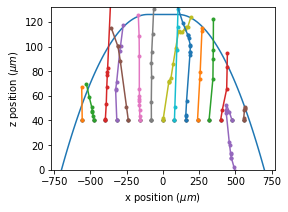

In [44]:
h = 40#np.random.uniform(0, gm.H)

xs = np.linspace(-gm.R, gm.R, 100)
plt.plot(xs, gm.h(xs))
# plt.show()

xs1 = linspace1(-gm.r(h), gm.r(h),15)
sim = [CLSM_Simulation(gm, l_mfp=25, max_scatters=50) 
        for i in range(len(xs1))] 

for xi, x in enumerate(tqdm(xs1)):

    plt.plot(x,h, "k.")

    sim[xi].run([x,0,h], fp_z=h, N_photons=1, save_positions=True)
    plt.plot(sim[xi].positions[0,:,0], sim[xi].positions[0,:,2], ".-")
    plt.xlabel("x position ($\mu m$)")
    plt.ylabel("z position ($\mu m$)")
    plt.ylim(0,None)

### I believe all of the below was a way to compare scattering and absorption for CLSM and widefield.
The biofilm geometries are intended to be very large and cylindrical, to mock an infinite plane, so we can only look at depth into that plane the photons were emitted from.
I think the same code cells were reused with different parameters and parts commented out to produce both of the plots that are currently cached in output.

In [45]:
import matplotlib.colors
import matplotlib.cm

def cbar(vmin, vmax, name):
    norm = matplotlib.colors.LogNorm(vmin=vmin, vmax=vmax)
    cb_map = matplotlib.cm.ScalarMappable(norm=norm, cmap="viridis")
    plt.colorbar(cb_map).set_label(name) 

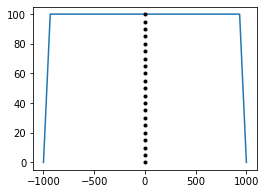

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

In [46]:
gmc = CylinderBiofilm(1000,100)
x = 0#p.random.uniform(-gmc.R, gmc.R)
xs = np.linspace(-gmc.R, gmc.R, 31)
hs = np.linspace(0, gmc.h(), 21)

plt.plot(xs, gmc.h(xs))
plt.plot([x]*len(hs), hs, "k.")
plt.show()

l_mfps = [5, 10, 20, 50, 100, 200, 500, 1000]
# aperture_r=0.52
sims_cf = [
    [Widefield_Simulation(gmc, ccd_xs, ccd_ys, g=.85, l_mfp=l, max_scatters=25, absorb_prop=0) for i in range(len(hs))]
    # [CLSM_Simulation(gmc, g=.85, aperture_r=.52, l_mfp=l, max_scatters=25) for i in range(len(hs))]
    for l in l_mfps
]
# sims_wf = [Widefield_Simulation(gmc, aperture_r=1) for i in range(len(hs))]

for j in range(len(l_mfps)):
    for hi, h in enumerate(tqdm(hs)):
        sims_cf[j][hi].run([0,0,h], fp_z=h, N_photons=1000)

# plt.twinx()
# plt.plot(hs,[sim.mean_n_scatters for sim in sims_cf],"tab:orange")
# plt.show()
norm_scatter_depth_wf = sims_cf.copy()

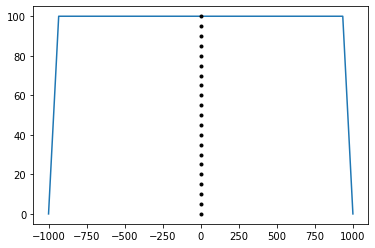

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

In [25]:
gmc = CylinderBiofilm(1000,100)


# Widefield_Simulation(gm, xs, ys, g=.92, l_mfp=10, max_scatters=200)
ccd_xs, ccd_ys = np.linspace(-5000,5000,31), np.linspace(-5000,5000,31)

x = 0#p.random.uniform(-gmc.R, gmc.R)
xs = np.linspace(-gmc.R, gmc.R, 31)
hs = np.linspace(0, gmc.h(), 21)

plt.plot(xs, gmc.h(xs))
plt.plot([x]*len(hs), hs, "k.")
plt.show()

l_mfps = [5, 10, 20, 50, 100, 200, 500, 1000]
# aperture_r=0.52
sims_cf = [
    [Widefield_Simulation(gmc, ccd_xs, ccd_ys, g=.85, l_mfp=l, max_scatters=25, absorb_prop=1) for i in range(len(hs))]
    # [CLSM_Simulation(gmc, g=.85, aperture_r=.52, l_mfp=l, max_scatters=25, absorb_prop=1) for i in range(len(hs))]
    for l in l_mfps
]
# sims_wf = [Widefield_Simulation(gmc, aperture_r=1) for i in range(len(hs))]

for j in range(len(l_mfps)):
    for hi, h in enumerate(tqdm(hs)):
        sims_cf[j][hi].run([0,0,h], fp_z=h, N_photons=1000)
        
norm_absorb_depth_wf = sims_cf.copy()        

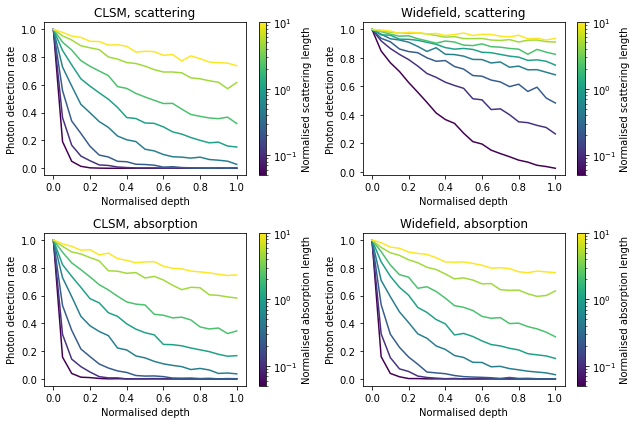

In [203]:
fig, axs = plt.subplots(2,2,figsize=(9,6))

axs = axs.flatten()

cm = plt.get_cmap("viridis")
cs = cm(np.linspace(0,1,len(l_mfps)))

for i, sims in enumerate([norm_scatter_depth, norm_scatter_depth_wf, norm_absorb_depth, norm_absorb_depth_wf]):
    plt.sca(axs[i])
    for j, l_mfp in enumerate(l_mfps):
        plt.plot(1-hs/100,[sim.fraction_detected for sim in sims[j]], c=cs[j], label=l_mfp)

    plt.ylabel("Photon detection rate")
    plt.xlabel("Normalised depth")

    if i <= 1:
        cbar(l_mfps[0]/100, l_mfps[-1]/100, "Normalised scattering length")
        if i == 0:
            plt.title("CLSM, scattering")
        elif i == 1:
            plt.title("Widefield, scattering")
        
    else:
        cbar(l_mfps[0]/100, l_mfps[-1]/100, "Normalised absorption length")
        if i == 2:
            plt.title("CLSM, absorption")
        elif i == 3:
            plt.title("Widefield, absorption")
plt.tight_layout()
plt.savefig("D:/figs/normalised_optical_effects.svg")

In [110]:
#l_mfp_true = 10 to 40
#normalised = ~0.08 to 0.32
print(gm.H)


126.0


In [107]:
xs, ys = np.linspace(-700,700,31), np.linspace(-700,700,31)

l_mfps = [1,1.3,1.7,2,3.5,5,7.5,10,30,70,100,1e4]
l_mfps1 = [8e-1,1,1.3,1.7,2,3.5,5,7.5,10,30,70,100,1e4]

totals = []

for l in l_mfps:

    sim = Widefield_Simulation(gm, xs, ys, g=.85, l_mfp=gm.H*l/100, max_scatters=50, absorb_prop=0)

    illumination_delta = 50
    hs = linspace1(0,gm.H,10)
    for h in tqdm(hs):
        pts = hslice_xy_coords(h, gm, N=30)
        for pt in pts.T:

            sim.run(np.array([pt[0],pt[1],h]), fp_z=.5*gm.H, N_photons=5, aperture_pos=np.array([0,0]), do_tqdm=False, inverted=False)
    totals.append(np.sum(sim.image))
# img_pts = np.array(sim.images)
# plt.plot(img_pts[:,0], img_pts[:,1], "r.")
# plt.imshow(sim.image, extent=[xs[0],xs[-1],ys[0],ys[-1]])

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

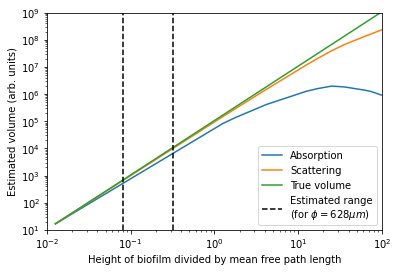

In [117]:
plt.plot(gm.H/np.array(l_mfps1), np.array(totals1)*gm.aspect*(gm.R/np.array(l_mfps1))**2, label="Absorption")
plt.plot(gm.H/np.array(l_mfps), np.array(totals)*gm.aspect*(gm.R/np.array(l_mfps))**2, label="Scattering")
plt.plot(gm.H/np.array(l_mfps), totals1[-1]*gm.aspect*(gm.R/np.array(l_mfps))**2, label="True volume")
# print(totals)
plt.xlim(1e-2, 1e2)
plt.ylim(1e1, 1e9)

plt.axvline(x=0.08, color="k", linestyle="--")
plt.axvline(x=0.32, color="k", linestyle="--", label="Estimated range\n(for $\phi=628\mu m$)")
plt.loglog()
plt.legend()
plt.xlabel("Height of biofilm divided by mean free path length")
plt.ylabel("Estimated volume (arb. units)")
plt.savefig("D:/figs/extrapolation.svg")

In [ ]:
l_mfp = l/r